## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction
In this project you will: 

Use a Tokenizer in TensorFlow

Pad and Truncate Sequences

Create and Train a Recurrent Neural Network

Use NLP and Deep Learning to perform Text Classification

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
dataset = nlp.load_dataset('emotion')
dataset

Using custom data configuration default


{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [4]:
train = dataset['train']
valid = dataset['validation']
test = dataset['test']

In [5]:
def get_data(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [6]:
train_t, train_l = get_data(train)
print(len(train_t), len(train_l))
train_t[0], train_l[0]

16000 16000


('i didnt feel humiliated', 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [7]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(train_t)
print(train_t[3])
print(tokenizer.texts_to_sequences([train_t[3]]))

i am ever feeling nostalgic about the fireplace i will know that it is still on the property
[[2, 24, 165, 8, 665, 27, 6, 4158, 2, 59, 47, 9, 13, 22, 72, 30, 6, 3497]]


## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

In [8]:
lengths = [len(t.split(' ')) for t in train_t]

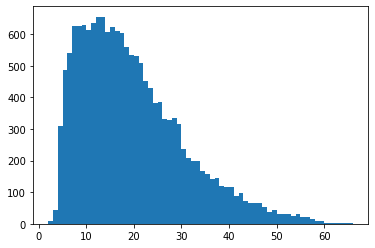

In [9]:
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [10]:
def get_sequences(tokenizer, train_t):
  sequences = tokenizer.texts_to_sequences(train_t)
  padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
  return padded_sequences

In [11]:
padded_train_t = get_sequences(tokenizer, train_t)
print(padded_train_t[0])
print(train_t[0])
print(tokenizer.texts_to_sequences([train_t[0]]))

[  2 139   3 679   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
i didnt feel humiliated
[[2, 139, 3, 679]]


## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [12]:
classes = set(train_l)
classes

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

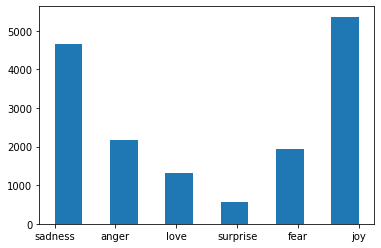

In [13]:
plt.hist(train_l, bins=11)
plt.show()

In [14]:
classes_to_index = dict((a,b) for b,a in enumerate(classes))
index_to_classes = dict((c,d) for c,d in enumerate(classes))

In [15]:
classes_to_index

{'anger': 0, 'fear': 3, 'joy': 2, 'love': 1, 'sadness': 5, 'surprise': 4}

In [16]:
index_to_classes

{0: 'anger', 1: 'love', 2: 'joy', 3: 'fear', 4: 'surprise', 5: 'sadness'}

In [17]:
name_to_ids = lambda label: np.array([classes_to_index.get(x) for x in label])

In [18]:
train_labels = name_to_ids(train_l)
train_labels[0], train_l[0]

(5, 'sadness')

## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [19]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Embedding(10000, 16, input_length=50),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
                                    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [20]:
val_t, val_l = get_data(valid)
val_sequences = get_sequences(tokenizer, val_t)
val_labels = name_to_ids(val_l)

In [21]:
val_t[0], val_l[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon',
 'sadness',
 5)

In [22]:
val_labels.shape

(2000,)

In [23]:
history = model.fit(
    padded_train_t, train_labels, 
    validation_data = (val_sequences, val_labels),
    epochs = 20,
    callbacks = [
                 tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)
                 ]
)

Epoch 1/20
500/500 [==============================] - 39s 64ms/step - loss: 1.3333 - accuracy: 0.4741 - val_loss: 0.9046 - val_accuracy: 0.6750
Epoch 2/20
500/500 [==============================] - 28s 55ms/step - loss: 0.6101 - accuracy: 0.7861 - val_loss: 0.5855 - val_accuracy: 0.8030
Epoch 3/20
500/500 [==============================] - 28s 56ms/step - loss: 0.3568 - accuracy: 0.8793 - val_loss: 0.4984 - val_accuracy: 0.8315
Epoch 4/20
500/500 [==============================] - 29s 57ms/step - loss: 0.2568 - accuracy: 0.9101 - val_loss: 0.4581 - val_accuracy: 0.8455
Epoch 5/20
500/500 [==============================] - 29s 57ms/step - loss: 0.1793 - accuracy: 0.9402 - val_loss: 0.4221 - val_accuracy: 0.8770
Epoch 6/20
500/500 [==============================] - 29s 57ms/step - loss: 0.1424 - accuracy: 0.9548 - val_loss: 0.4145 - val_accuracy: 0.8740
Epoch 7/20
500/500 [==============================] - 29s 57ms/step - loss: 0.1136 - accuracy: 0.9634 - val_loss: 0.4086 - val_accuracy:

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

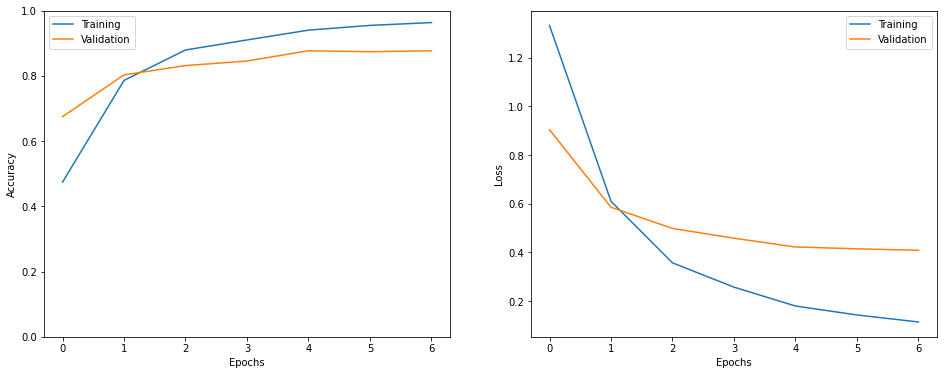

In [24]:
show_history(history)

In [27]:
test_t, test_l = get_data(test)
test_sequences = get_sequences(tokenizer, test_t)
test_labels = name_to_ids(test_l)

In [28]:
model.evaluate(test_sequences, test_labels)

63/63 [==============================] - 1s 23ms/step - loss: 0.4111 - accuracy: 0.8720


[0.41110047698020935, 0.871999979019165]

In [32]:
i = random.randint(0, len(test_l)-1)

print("Sequence: ", test_sequences[i])
print("Emotion: ", test_l[i])

p = model.predict(np.expand_dims(test_sequences[i],axis=0))[0]
pred_emo = index_to_classes[np.argmax(p).astype('uint8')]
print("Predicted emotion: ", pred_emo)

Sequence:  [   2   21    7    8    9   79   94 1201    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
Emotion:  joy
Predicted emotion:  joy


In [44]:
pred_emos = model.predict(test_sequences)
pred = [np.argmax(x) for x in pred_emos]
preds = np.asarray(pred)
preds.shape

(2000,)

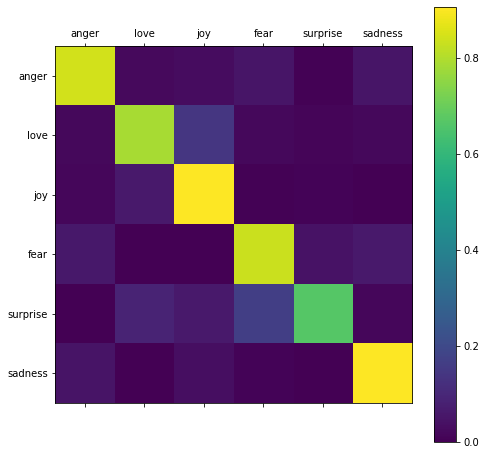

In [45]:
show_confusion_matrix(test_labels, preds, list(classes))